In [35]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

In [2]:
games = pd.read_csv("games_2011_to_2023.csv", parse_dates=["date"])
wins = games.loc[games.result == "W"]
schools = pd.read_csv("general_data/schools.csv", skiprows=1, header=None, names=["school_id", "school_name"]).set_index("school_id")

In [51]:
class ELO:
    def __init__(
        self,
        winners,
        losers,
        ids=None,
        timestamps=None,
        k=20,
        elo_init=1500,
        elo_diff=400,
    ):
        self.k = k
        self.elo_init = 1500
        self.elo_diff = 400

        ELO.__check_valid_games__(winners, losers, ids, timestamps)
        ELO.__check_valid_params__(k, elo_init, elo_diff)

        # Assemble temporary empty dataframe to store ELOs
        self.competitors = sorted(
            list(set(winners) | set(losers))
        )
        init_elos = pd.DataFrame(columns=self.competitors, index=ids if ids is not None else range(len(winners)))
        init_elos.iloc[0, :] = self.elo_init

        # Initialize dataframe to store all competitions and ELOs
        self.elo_df = pd.DataFrame(
            {"id": ids, 'timestamp': timestamps, "winner": winners, "loser": losers}
        ).set_index("id")
        self.elo_df = pd.concat([self.elo_df, init_elos], axis=1)

        # Sort the dataframe by timestamp then index
        if timestamps is not None:
            self.elo_df = self.elo_df.sort_values(["timestamp"])

    # Compute the ELO of every competitor after each match (37s original)
    def fit(self):
        for i in tqdm(range(len(self.elo_df))):
            row = self.elo_df.iloc[i]
            winner_id = row["winner"]
            loser_id = row["loser"]

            winner_init_elo = (
                self.elo_df.iloc[i - 1][winner_id] if i > 0 else self.elo_init
            )
            loser_init_elo = (
                self.elo_df.iloc[i - 1][loser_id] if i > 0 else self.elo_init
            )

            winner_new_elo, loser_new_elo = ELO.compute_pairwise_elo(
                winner_init_elo, loser_init_elo, elo_diff=self.elo_diff, k=self.k
            )
            if i > 0:
                self.elo_df.iloc[i, 3:] = self.elo_df.iloc[i - 1, 3:]
            self.elo_df.loc[row.name, winner_id] = winner_new_elo
            self.elo_df.loc[row.name, loser_id] = loser_new_elo

    # 9s
    def fit_fast(self):
        elo_dict = {competitor: self.elo_init for competitor in self.competitors}
        elo_changes = {}
        game_array = self.elo_df.reset_index()[['id', 'winner', 'loser']].values
        elo_array = np.ones((len(game_array), len(self.competitors))) * self.elo_init
        team_indices = {team: i for i, team in enumerate(self.competitors)}
        for i, game in tqdm(enumerate(game_array)):
            game_id, winner, loser = game[0], game[1], game[2]
            winner_elo, loser_elo = elo_dict[winner], elo_dict[loser]
            winner_new_elo, loser_new_elo = ELO.compute_pairwise_elo(winner_elo, loser_elo, elo_diff=self.elo_diff, k=self.k)
            elo_dict[winner], elo_dict[loser] = winner_new_elo, loser_new_elo
            elo_changes[game_id] = {winner: winner_new_elo, loser: loser_new_elo}
            new_game_row = elo_array[-1]
            new_game_row[team_indices[winner]], new_game_row[team_indices[loser]] = winner_new_elo, loser_new_elo
            elo_array = np.vstack([elo_array, new_game_row])
        return elo_array
    
    # 0.04476022720336914s (without dataframe conversion)
    # 0.15063881874084473 (with dataframe conversion)
    def fit_fastest(self):
        elo_dict = {competitor: self.elo_init for competitor in self.competitors}
        elo_changes = {}
        game_array = self.elo_df.reset_index()[['id', 'winner', 'loser']].values
        elo_array = [np.ones(len(self.competitors)) * self.elo_init]
        team_indices = {team: i for i, team in enumerate(self.competitors)}
        for i, game in tqdm(enumerate(game_array)):
            game_id, winner, loser = game[0], game[1], game[2]
            winner_elo, loser_elo = elo_dict[winner], elo_dict[loser]
            winner_new_elo, loser_new_elo = ELO.compute_pairwise_elo(winner_elo, loser_elo, elo_diff=self.elo_diff, k=self.k)
            elo_dict[winner], elo_dict[loser] = winner_new_elo, loser_new_elo
            elo_changes[game_id] = {winner: winner_new_elo, loser: loser_new_elo}
            new_game_row = elo_array[max(0, i - 1)].copy()
            new_game_row[team_indices[winner]], new_game_row[team_indices[loser]] = winner_new_elo, loser_new_elo
            elo_array.append(new_game_row)
        return pd.concat([self.elo_df[['winner', 'loser']], pd.DataFrame(elo_array[1:], columns=self.competitors, index=self.elo_df.index)], axis=1)
    

    @staticmethod
    def compute_pairwise_elo(winner_elo, loser_elo, elo_diff, k):
        expected_outcome_prob = ELO.compute_expected_outcome_prob(
            winner_elo, loser_elo, elo_diff=elo_diff
        )
        return winner_elo + k * (1 - expected_outcome_prob), loser_elo - k * (
            1 - expected_outcome_prob
        )

    @staticmethod
    def compute_expected_outcome_prob(elo1, elo2, elo_diff=400):
        return 1 / (1 + 10 ** ((elo2 - elo1) / elo_diff))

    @staticmethod
    def __check_valid_params__(k, elo_init, elo_diff):
        assert isinstance(k, int) and k > 0
        assert isinstance(elo_init, int) and elo_init > 0
        assert isinstance(elo_diff, int) and elo_diff > 0

    @staticmethod
    def __check_valid_games__(winners, losers, ids, timestamps):
        # assert proper data types
        assert pd.api.types.is_list_like(winners)
        assert pd.api.types.is_list_like(losers)
        assert ids is None or pd.api.types.is_list_like(ids)
        assert timestamps is None or pd.api.types.is_list_like(timestamps)

        # check that winners, losers, ids, and timestamps have the same length
        assert len(winners) == len(losers)
        assert ids is None or len(ids) == len(winners)
        assert timestamps is None or len(timestamps) == len(winners)

        # check that all ids are unique
        assert ids is None or len(set(ids)) == len(ids)

        # check that no teams play against themselves
        for i in range(len(winners)):
            assert winners[i] != losers[i]

        # check that the timestamps are valid
        if timestamps is not None:
            for timestamp in timestamps:
                try:
                    pd.to_datetime(timestamp)
                except ValueError:
                    raise ValueError("Invalid timestamp: {}".format(timestamp))

    def show_elos(self):
        return self.elo_df

In [4]:
elo_df = (
    wins[["date", "contest_id", "school_id", "opponent_school_id"]]
    .sort_values(by="date")
    .set_index("date")
)
elo_df.columns = ["id", "winner", "loser"]

In [ ]:
e = ELO(elo_df.winner, elo_df.loser, ids=elo_df.id, timestamps=elo_df.index)
e.fit()
e.show_elos()

In [ ]:
# 9s

In [53]:
e = ELO(elo_df.winner, elo_df.loser, ids=elo_df.id, timestamps=elo_df.index)

C:\Users\19083\AppData\Local\Temp\ipykernel_10904\3597142345.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert winners[i] != losers[i]


In [54]:
start = time.time()
array = e.fit_fastest()
print(time.time() - start)

6262it [00:00, 225114.05it/s]

0.15063881874084473


In [55]:
array

,winner,loser,14,52,62,68,80,81,83,116,...,738,739,741,746,748,813,1320,11504,19651,30136
id,,,,,,,,,,,,,,,,,,,,,
869377.0,180,184,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
869378.0,518,184,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
869391.0,52,184,1500.000000,1509.433244,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
869379.0,193,639,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
869386.0,180,1320,1500.000000,1509.433244,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1490.287744,1500.000000,1500.000000,1500.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2433933.0,513,322,1530.501514,1333.656374,1405.930448,1647.364531,1606.632263,1537.837589,1473.230322,1212.840854,...,1584.048434,1664.209548,1163.584714,1850.958412,1144.469566,1768.852620,1428.600730,1389.497990,1537.592961,1416.239804
2433934.0,539,725,1528.984088,1361.176001,1412.930933,1637.899544,1594.985103,1532.154758,1501.476075,1234.448703,...,1595.952416,1672.282229,1159.890639,1873.631026,1136.034335,1776.038591,1437.542888,1395.570149,1530.916038,1403.517020
2433918.0,193,539,1530.501514,1333.656374,1405.930448,1647.364531,1606.632263,1537.837589,1473.230322,1212.840854,...,1584.048434,1664.209548,1163.584714,1850.958412,1144.469566,1768.852620,1428.600730,1389.497990,1537.592961,1416.239804


In [16]:
e.show_elos().reset_index().values

array([[869377.0, Timestamp('2011-02-05 00:00:00'), 180, ..., nan, nan,
        nan],
       [869378.0, Timestamp('2011-02-10 00:00:00'), 518, ..., 1500.0,
        1490.0, 0.5143871841659987],
       [869391.0, Timestamp('2011-02-12 00:00:00'), 52, ..., 1500.0,
        1480.28774368332, 0.5283378170434969],
       ...,
       [2433918.0, Timestamp('2023-05-27 00:00:00'), 193, ...,
        1867.9958761741893, 1676.900477359287, 0.7502663902330422],
       [2433917.0, Timestamp('2023-05-27 00:00:00'), 513, ...,
        1838.5164954929219, 1873.6310258451758, 0.44963749111965307],
       [2433932.0, Timestamp('2023-05-29 00:00:00'), 513, ...,
        1849.5237456705288, 1872.9905483695286, 0.46627981823926107]],
      dtype=object)

In [6]:
df = e.show_elos()
nf = df.rename(columns={school: schools.loc[school].school_name for school in df.columns[3:]})

In [7]:
school_dict = schools.to_dict()['school_name']
df['winner_name'] = df.apply(lambda x: school_dict[x.winner], axis=1)
df['loser_name'] = df.apply(lambda x: school_dict[x.loser], axis=1)
df_prev = pd.concat([df.iloc[:, :3], df.iloc[:, 3:].shift()], axis=1)
df['winner_prev_elo'] = df_prev.apply(lambda x: x[x.winner], axis=1)
df['loser_prev_elo'] = df_prev.apply(lambda x: x[x.loser], axis=1)

In [8]:
df['winner_win_prob'] = df.apply(lambda x: ELO.compute_expected_outcome_prob(x.winner_prev_elo, x.loser_prev_elo), axis=1)

In [9]:
df[['timestamp', 'winner_name', 'loser_name', 'winner_win_prob']].sort_values(by='winner_win_prob')

,timestamp,winner_name,loser_name,winner_win_prob
id,,,,
2360289.0,2023-04-01,Michigan,Maryland,0.071895
2164304.0,2022-02-13,Jacksonville,Duke,0.074304
2359434.0,2023-03-11,NJIT,Lindenwood,0.082142
144674.0,2018-04-06,UMBC,UAlbany,0.090453
2164471.0,2022-02-22,Lafayette,Drexel,0.095010
...,...,...,...,...
1676350.0,2019-04-16,Virginia,VMI,0.960729
2164233.0,2022-02-11,Duke,Manhattan,0.963526
2361284.0,2023-04-25,Virginia,Lafayette,0.964769


In [10]:
df.loc[df.timestamp > '2020'].winner_win_prob.describe()

count    1714.000000
mean        0.618090
std         0.188196
min         0.071895
25%         0.482762
50%         0.635510
75%         0.766740
max         0.972209
Name: winner_win_prob, dtype: float64

In [11]:
import pandas as pd

# Create a Series with out-of-order numeric index
data = [10, 20, 30, 40]
index = [3, 1, 4, 2]
series = pd.Series(data, index=index)

# Access elements by their index using loc
print(series.loc[1])  # Access element with index 1
print(series.loc[2])  # Access element with index 2
print(series.loc[3])  # Access element with index 3
print(series.loc[4])  # Access element with index 4


20
40
10
30


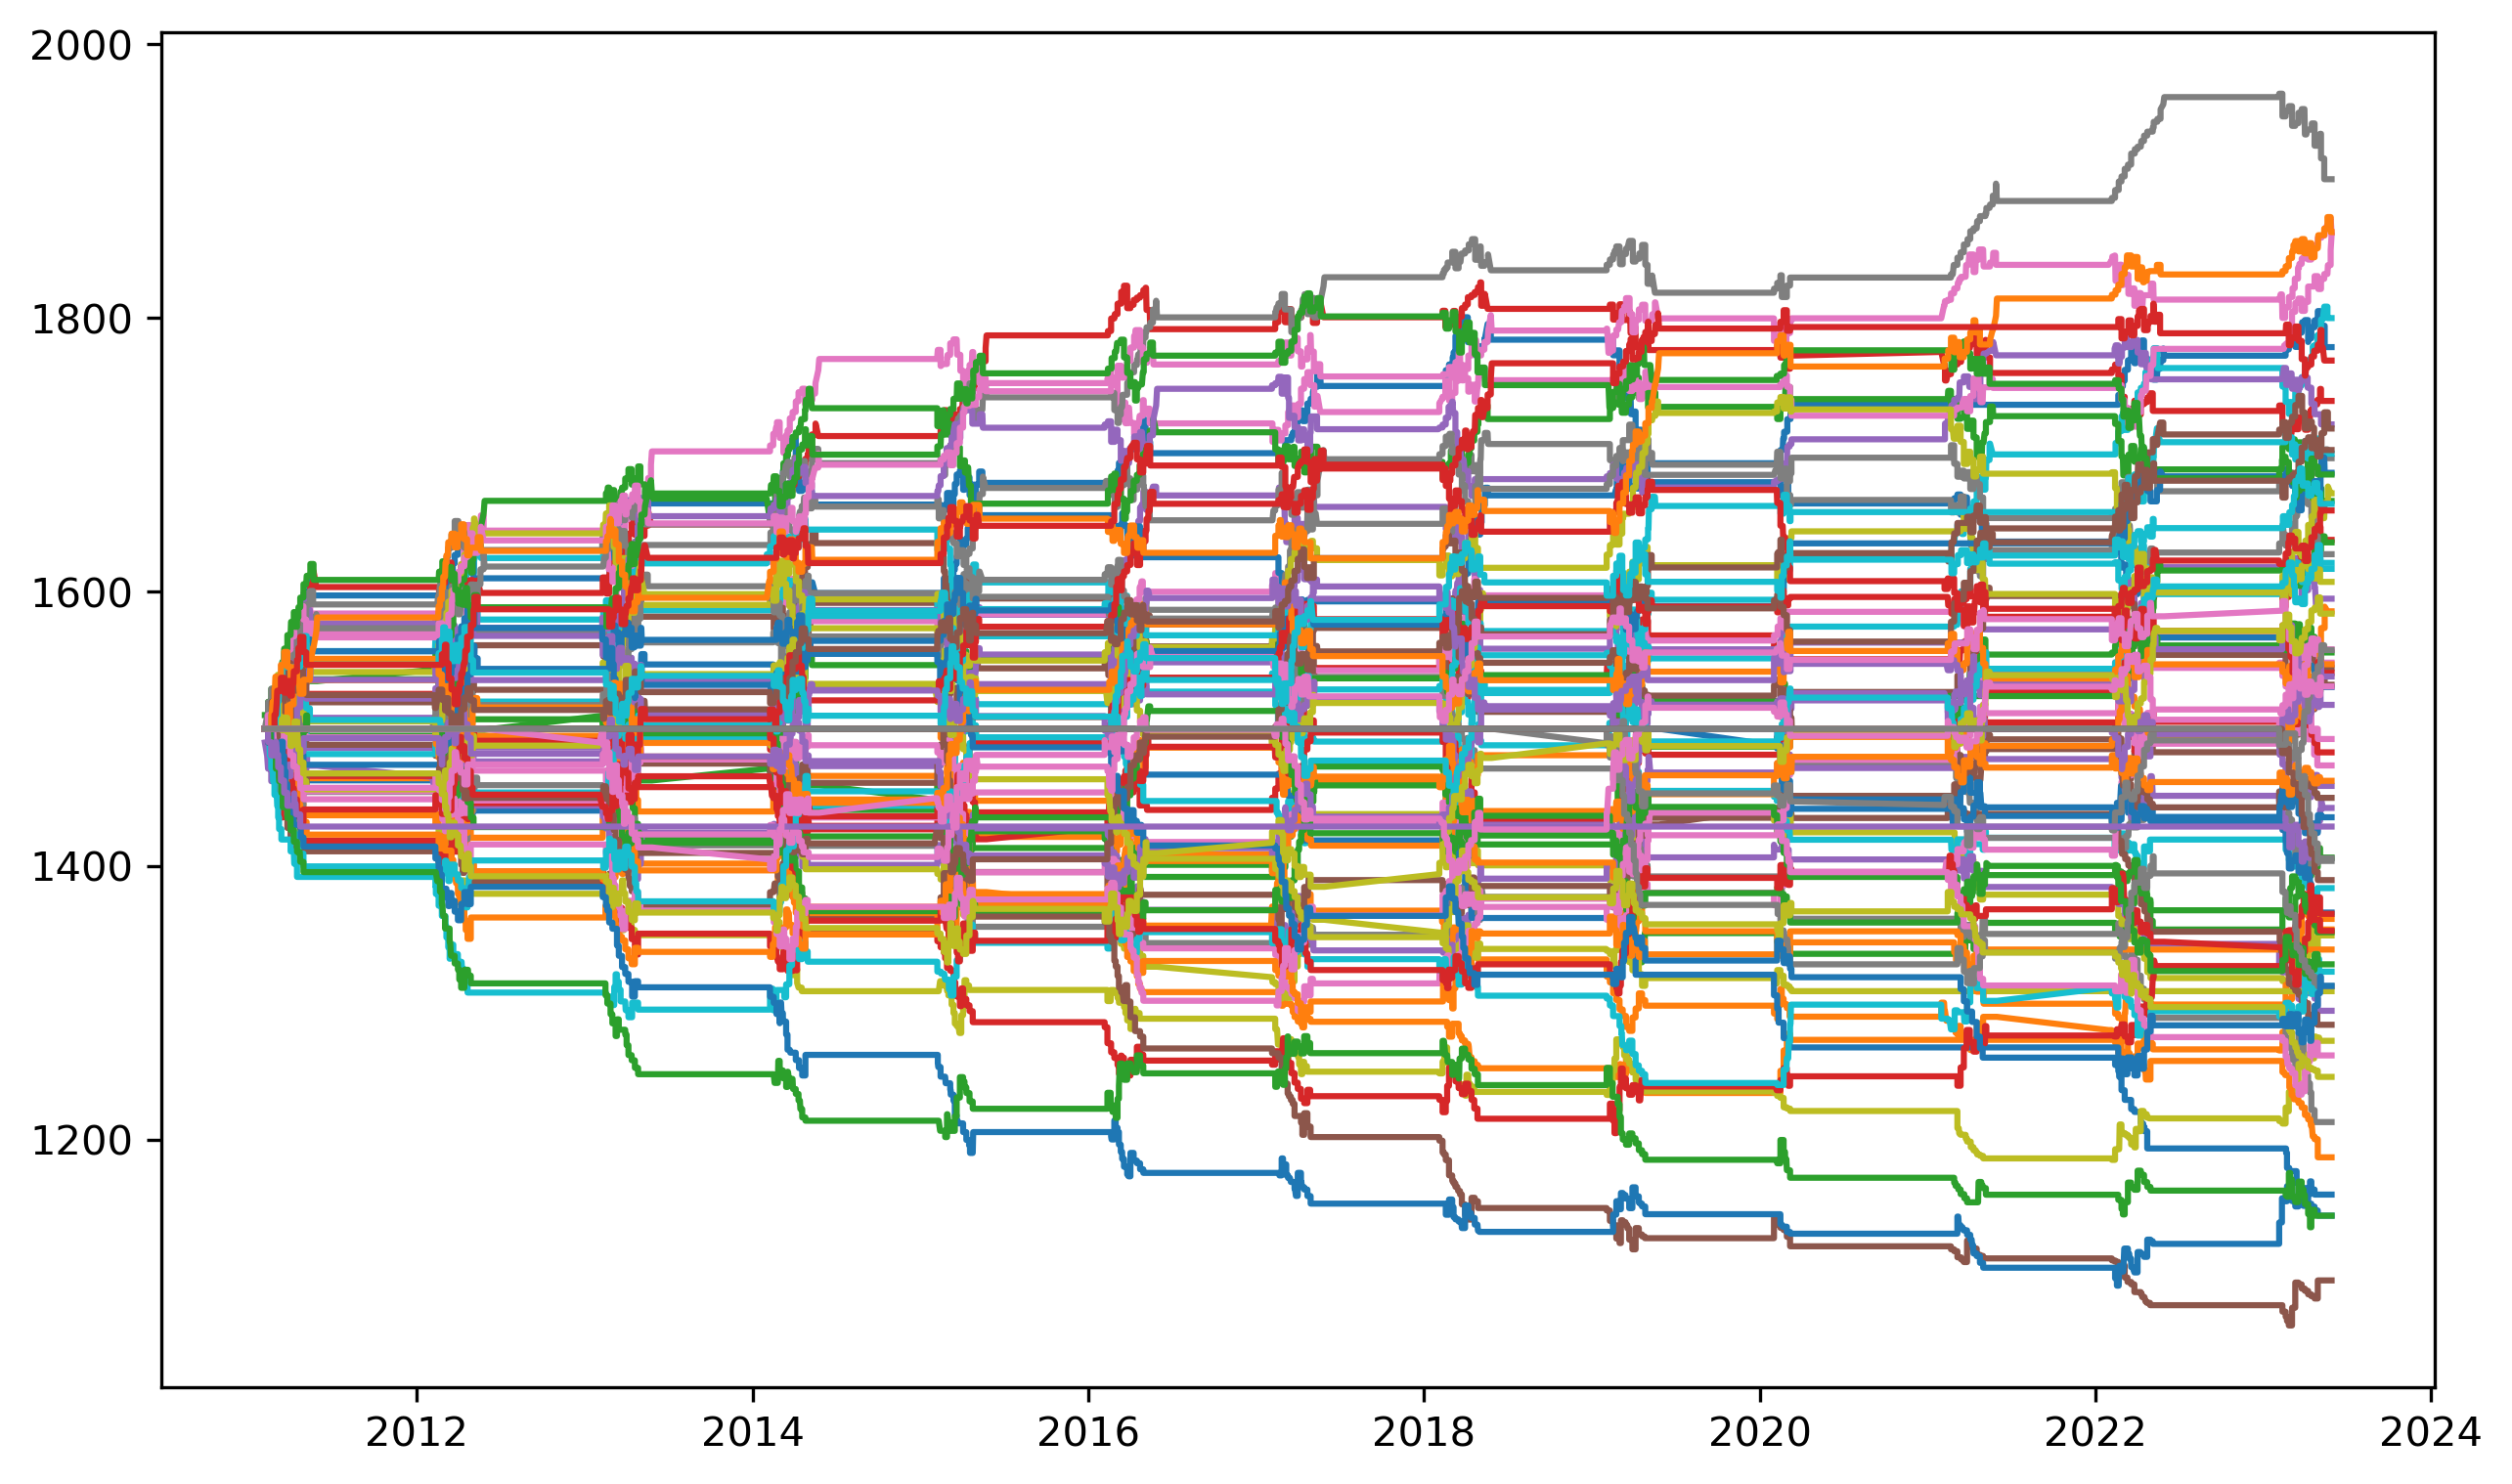

In [12]:
plt.figure(dpi=300, figsize=(10, 6))
for team in nf.columns[3:]:
    plt.plot(nf.timestamp, nf[team], label=team)
# plt.legend()

In [13]:
nf.apply(lambda x: ELO.compute_expected_outcome_prob(x.winner, x.loser), axis=1).sort_values()

id
2360255.0    6.165950e-76
2359704.0    1.071519e-75
2360641.0    1.318257e-75
2360796.0    2.818383e-75
2358496.0    4.241310e-75
                 ...     
680791.0     1.000000e+00
2033363.0    1.000000e+00
1674999.0    1.000000e+00
1675877.0    1.000000e+00
144446.0     1.000000e+00
Length: 6262, dtype: float64

In [14]:
nf.loc[144446]

timestamp       2018-03-31 00:00:00
winner                        19651
loser                           316
UAlbany                 1796.866423
Bellarmine              1335.768958
                       ...         
Yale                    1717.755197
Presbyterian             1428.60073
Queens (NC)                    1500
High Point              1406.635214
Lindenwood                     1500
Name: 144446.0, Length: 81, dtype: object